In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import flwr as fl
import tensorflow as tf
from collections import OrderedDict, defaultdict
from typing import Dict, List, Optional, Tuple
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import StratifiedKFold, KFold
from flwr.common.logger import log
from logging import INFO, DEBUG

import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [3]:
DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.3.0+cpu and Flower 1.7.0


In [4]:
df_1 = pd.read_csv('features_data/features_cpsc_2018_extra.csv')
df_2 = pd.read_csv('features_data/features_cpsc_2018.csv')
df_3 = pd.read_csv('features_data/features_georgia.csv')
df_4 = pd.read_csv('features_data/features_incart.csv')
df_5 = pd.read_csv('features_data/features_ptb.csv') 
df_6 = pd.read_csv('features_data/features_ptb-xl.csv')

In [5]:
# merge all dfs
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6], ignore_index=True)
df.shape

(30088, 653)

In [6]:
feature_i_df = pd.read_csv(r"top_120_features.csv")
feature_i_df.head()

,Feature Id,Importances
0,std_coeff_4_9,3.416952
1,sex,2.940475
2,var_coeff_3_5,1.884608
3,n25_coeff_4_10,1.677882
4,n75_coeff_4_6,1.377380


In [7]:
feature_names = list(feature_i_df["Feature Id"])
feature_names[:50]

['std_coeff_4_9',
 'sex',
 'var_coeff_3_5',
 'n25_coeff_4_10',
 'n75_coeff_4_6',
 'n95_6',
 'std_Peaks',
 'mean_coeff_1_6',
 'var_coeff_3_0',
 'mean_6',
 'n95_coeff_0_4',
 'kurt_Peaks',
 'n5_coeff_3_11',
 'n75_coeff_4_10',
 'n75_coeff_4_11',
 'n75_6',
 'std_coeff_0_6',
 'n75_11',
 'n75_1',
 'median_coeff_1_11',
 'mean_2',
 'mean_8',
 'median_Peaks',
 'skew_Peaks',
 'var_coeff_4_9',
 'n95_coeff_3_6',
 'var_Peaks',
 'var_coeff_3_1',
 'n25_6',
 'n95_coeff_0_2',
 'var_RR',
 'median_coeff_0_11',
 'n95_9',
 'mean_11',
 'n95_coeff_4_3',
 'n5_coeff_4_3',
 'entropy_1_8',
 'n5_8',
 'std_coeff_2_6',
 'entropy_1_2',
 'median_coeff_0_10',
 'std_3',
 'mean_7',
 'n95_coeff_1_11',
 'n5_3',
 'median_coeff_4_7',
 'mean_4',
 'n25_3',
 'std_coeff_4_0',
 'skew_RR']

In [8]:
df_copy = df.dropna()

In [9]:
df_copy = df_copy.groupby('label').filter(lambda x: len(x) >= 1100)

In [10]:
# remove "TAb" and "IAVB" from df_copy
df_copy = df_copy[df_copy['label'] != "TAb"]
df_copy = df_copy[df_copy['label'] != "IAVB"]

df_copy['label'].value_counts()

label
NSR     13781
AF       2124
RBBB     1845
LAD      1675
SB       1266
Name: count, dtype: int64

In [25]:
# split data into train val and test sets stratified by target
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#X = df_copy.drop(columns=['label',"label_abr","merged_labels","id","id.1"])
X = df_copy.drop(columns=['label',"id"])
X = X[feature_names[:150]]
#scale the X
from sklearn.preprocessing import StandardScaler, LabelEncoder,RobustScaler
# scaler = StandardScaler()
# #scaler = RobustScaler()
# X = scaler.fit_transform(X)



y = df_copy['label']
#convert y into integers
le = LabelEncoder()
y = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)


In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_non_iid_partitions(X, y, n_clients, alpha=0.5):
    # Ensure X is a DataFrame for consistent indexing
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    
    # Determine unique classes and their counts
    classes = np.unique(y)
    n_classes = len(classes)
    
    # Initialize lists to hold data for each client
    client_data = {i: [] for i in range(n_clients)}
    
    # Process each class separately
    for c in classes:
        # Find indices of data points belonging to the current class
        class_indices = np.where(y == c)[0]
        X_class = X.iloc[class_indices]
        y_class = y[class_indices]
        
        # Ensure each client gets at least one data point from the current class
        min_per_client = min(n_clients, len(class_indices))
        for i in range(min_per_client):
            idx = i % len(class_indices)
            client_data[i].append((X_class.iloc[[idx]], y_class[[idx]]))
        
        # Remove the data points that have already been assigned
        remaining_indices = np.delete(np.arange(len(class_indices)), np.arange(min_per_client) % len(class_indices))
        X_class_remaining = X_class.iloc[remaining_indices]
        y_class_remaining = y_class[remaining_indices]
        
        # Create a probability distribution for assigning remaining data points to clients
        probs = np.random.dirichlet(np.repeat(alpha, n_clients))
        
        # Assign remaining data points to clients based on the distribution
        if len(remaining_indices) > 0:
            class_assignments = np.random.choice(np.arange(n_clients), size=len(remaining_indices), p=probs)
            for i in range(n_clients):
                indices = np.where(class_assignments == i)[0]
                if len(indices) > 0:
                    client_data[i].append((X_class_remaining.iloc[indices], y_class_remaining[indices]))
    
    # Create data loaders for each client
    loaders = []
    for i in range(n_clients):
        # Combine data from all classes for the client
        if client_data[i]:
            X_client, y_client = zip(*client_data[i])
            X_client = pd.concat(X_client)
            y_client = np.concatenate(y_client)
        
            # Normalize the data
            scaler = StandardScaler()
            X_client = scaler.fit_transform(X_client)
        
            # Create a TensorDataset and DataLoader
            dataset = TensorDataset(torch.from_numpy(X_client).float(), torch.from_numpy(y_client).long())
            loader = DataLoader(dataset, batch_size=32)
            loaders.append(loader)
    
    return loaders

def create_data_loaders_non_iid(X_train, y_train, X_val, y_val, X_test, y_test, n_clients=4):
    train_loaders = create_non_iid_partitions(X_train, y_train, n_clients)
    val_loaders = create_non_iid_partitions(X_val, y_val, n_clients)
    
    # Normalize the test data based on the training data and create a DataLoader
    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loaders, val_loaders, test_loader

# Example usage
n_clients = 8
train_loaders, val_loaders, test_loader = create_data_loaders_non_iid(X_train, y_train, X_val, y_val, X_test, y_test, n_clients)


In [89]:
# get count of values in y_train
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))
print("Train data distribution: ", dict(zip(unique, counts)))

Train data distribution:  {0: 212, 1: 167, 2: 1379, 3: 185, 4: 127}


In [34]:
# Get a batch of data
batch = next(iter(train_loaders[3]))

# Print the first few samples
print(list(batch))

[tensor([[-0.0181,  1.0607, -0.2171,  ...,  0.3476, -0.4282, -0.1492],
        [ 1.0695,  1.0607, -0.2171,  ...,  0.9730,  0.0137,  0.2191],
        [-0.4687,  1.0607, -0.2171,  ..., -0.9361,  0.3323,  1.3628],
        ...,
        [ 0.2465, -0.9428, -0.2171,  ..., -1.1865, -0.1619, -1.0963],
        [-0.2511,  1.0607, -0.2171,  ..., -1.2590,  0.0772, -0.7837],
        [-0.2667, -0.9428, -0.2171,  ...,  0.1865,  0.4702, -0.2267]]), tensor([2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 2, 3, 0, 2, 2])]


<Axes: >

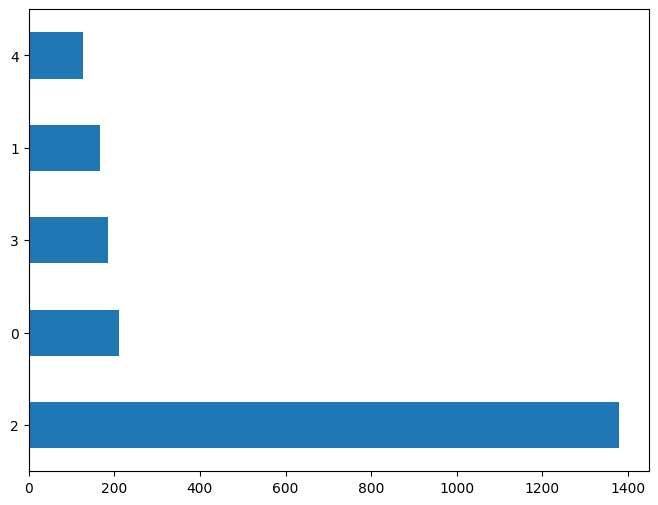

In [36]:
labels = [label for _, label in test_loader]
labels = np.concatenate(labels)  # Concatenate list of tensors into a single numpy array

# Convert labels to pandas Series
labels_series = pd.Series(labels)

# Count occurrences of each label
label_counts = labels_series.value_counts()

# Plot horizontal bar chart of label counts
label_counts.plot(kind='barh', figsize=(8, 6))



0    50
1    65
2    20
3    10
4     1
Name: count, dtype: int64


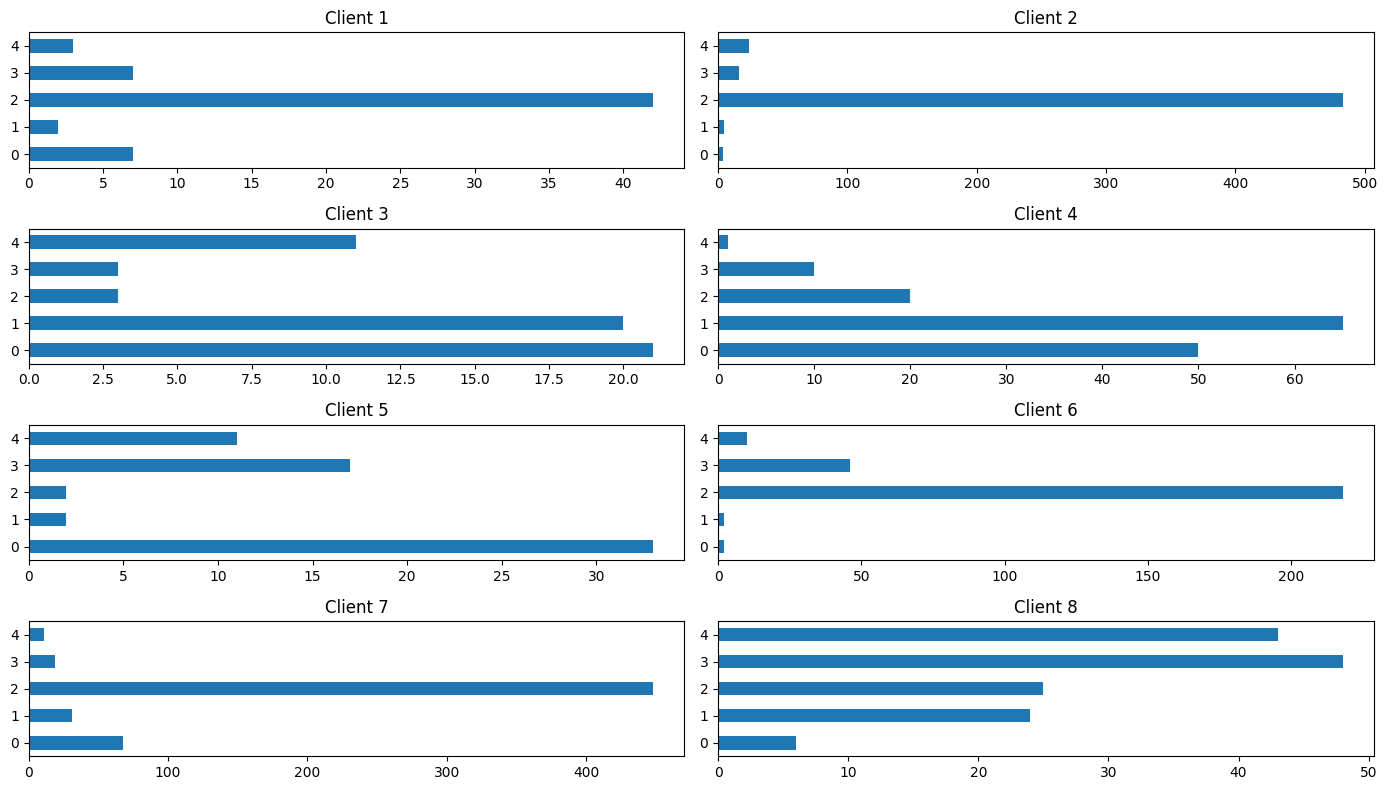

In [54]:
# Initialize a figure
fig, axs = plt.subplots(4,2, figsize=(14, 8))
axs = axs.flatten()
# Loop over each train loader
for i, train_loader in enumerate(val_loaders):
    # Get labels from train loader
    labels = [label for _, label in train_loader]
    labels = np.concatenate(labels)  # Concatenate list of tensors into a single numpy array

   # Convert labels to pandas Series
    labels_series = pd.Series(labels)

    # Count occurrences of each label
    label_counts = labels_series.value_counts().sort_index()

    if i==3:
        print(label_counts)

    # Plot horizontal bar chart of label counts
    label_counts.plot(kind='barh', ax=axs[i])
    axs[i].set_title(f'Client {i+1}')


plt.tight_layout()
plt.show()

In [55]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(150, 128)
        self.fc2 = nn.Linear(128, 500)
        self.fc4 = nn.Linear(500,5)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        #x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [56]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()

    with torch.no_grad():
        true_labels = []
        pred_labels = []
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    loss /= len(testloader.dataset)
    accuracy = correct/total
    # Calculate F1 score
    f1 = f1_score(true_labels, pred_labels, average='macro')
    precision = precision_score(true_labels, pred_labels, average='macro')
    recall = recall_score(true_labels, pred_labels, average='macro')
    return loss, accuracy,f1, precision, recall, true_labels, pred_labels

In [58]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=5)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy,f1, precision, recall,true_labels, pred_labels = test(self.net, self.valloader)
        #save_path = r"Non-IID Dist Scaling\8 clients\classification_report_client_"+str(self.cid)+"_8_clients.csv"
        # plt.savefig(save_path)
        # plt.show()
        #save the plot of confusion matrix
        #get classification report  and save it
        #get the classification report
        from sklearn.metrics import classification_report
        report = classification_report(true_labels, pred_labels,target_names=le.classes_,output_dict=True)
        report_df = pd.DataFrame(report).transpose()
        report_df.to_csv(save_path)
        log(INFO, f"Client side accuracy: {float(accuracy)}")
        return float(loss), len(self.valloader),{"accuracy": float(accuracy),
                                                 "f1": float(f1),
                                                 "precision":float(precision),
                                                 "recall":float(recall)}
    


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = train_loaders[int(cid)]
    valloader = val_loaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

In [59]:
# The `evaluate` function will be by Flower called after every round
def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net().to(DEVICE)
    valloader = test_loader
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy,f1, precision, recall, true_labels, pred_labels = test(net, valloader)
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix for Server Evaluation')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy,
                    "f1":float(f1),
                    "precision":float(precision),
                    "recall":float(recall)}





In [60]:
def average_metrics(metrics):
    """Aggregate metrics from multiple clients by calculating mean averages.

    Parameters:
    - metrics (list): A list containing tuples, where each tuple represents metrics for a client.
                    Each tuple is structured as (num_examples, metric), where:
                    - num_examples (int): The number of examples used to compute the metrics.
                    - metric (dict): A dictionary containing custom metrics provided as `output_dict`
                                    in the `evaluate` method from `client.py`.

    Returns:
    A dictionary with the aggregated metrics, calculating mean averages. The keys of the
    dictionary represent different metrics, including:
    - 'accuracy': Mean accuracy calculated by TensorFlow.
    - 'acc': Mean accuracy from scikit-learn.
    - 'rec': Mean recall from scikit-learn.
    - 'prec': Mean precision from scikit-learn.
    - 'f1': Mean F1 score from scikit-learn.

    Note: If a weighted average is required, the `num_examples` parameter can be leveraged.

    Example:
        Example `metrics` list for two clients after the last round:
        [(10000, {'prec': 0.108, 'acc': 0.108, 'f1': 0.108, 'accuracy': 0.1080000028014183, 'rec': 0.108}),
        (10000, {'f1': 0.108, 'rec': 0.108, 'accuracy': 0.1080000028014183, 'prec': 0.108, 'acc': 0.108})]
    """

    # Here num_examples are not taken into account by using _
    accuracies_tf = np.mean([metric["accuracy"] for _, metric in metrics])
    # accuracies = np.mean([metric["acc"] for _, metric in metrics])
    recalls = np.mean([metric["recall"] for _, metric in metrics])
    precisions = np.mean([metric["precision"] for _, metric in metrics])
    f1s = np.mean([metric["f1"] for _, metric in metrics])

    return {
        "accuracy": accuracies_tf,
        # "acc": accuracies,
        "rec": recalls,
        "prec": precisions,
         "f1": f1s,
    }

INFO flwr 2024-07-01 22:15:51,859 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=15, round_timeout=None)


2024-07-01 22:16:15,185	INFO worker.py:1749 -- Started a local Ray instance.
INFO flwr 2024-07-01 22:16:28,802 | app.py:213 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'node:127.0.0.1': 1.0, 'memory': 3938016462.0, 'object_store_memory': 1969008230.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0}
INFO flwr 2024-07-01 22:16:28,808 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-07-01 22:16:28,813 | app.py:227 | No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2024-07-01 22:16:28,813 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-07-01 22:16:29,163 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO flwr 2024-07-01 22:16:29,165 | server.py:89 | Initializing global parameters
INFO flwr 2024-07-01 22:16:29,177 | server.py:272 | Using initial p

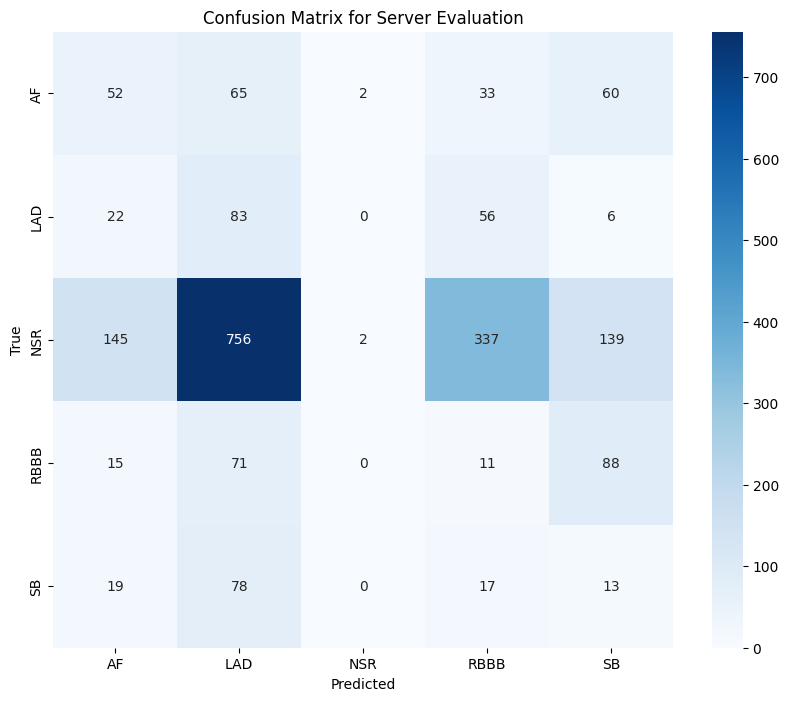

INFO flwr 2024-07-01 22:16:37,749 | server.py:94 | initial parameters (loss, other metrics): 0.052301721584393786, {'accuracy': 0.07777777777777778, 'f1': 0.09141774706271119, 'precision': 0.1702137488028554, 'recall': 0.18111219947983365}
INFO flwr 2024-07-01 22:16:37,752 | server.py:104 | FL starting
DEBUG flwr 2024-07-01 22:16:37,756 | server.py:222 | fit_round 1: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.052301721584393786 / accuracy 0.07777777777777778


(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=13816)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=13816) [Client 2] fit, config: {}
(DefaultActor pid=2476) Epoch 1: train loss 0.05889515206217766, accuracy 0.20924574209245742
(DefaultActor pid=2476) Epoch 2: train loss 0.03993534669280052, accuracy 0.635036496350365
(DefaultActor pid=2476) Epoch 3: train loss 0.034678537398576736, accuracy 0.583941605839416
(DefaultActor pid=2476) Epoch 4: train loss 0.029187742620706558, accuracy 0.6058394160583942
(DefaultActor pid=2476) Epoch 5: train loss 0.024738827720284462, accuracy 0.6715328467153284


DEBUG flwr 2024-07-01 22:17:24,947 | server.py:236 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2024-07-01 22:17:24,947 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


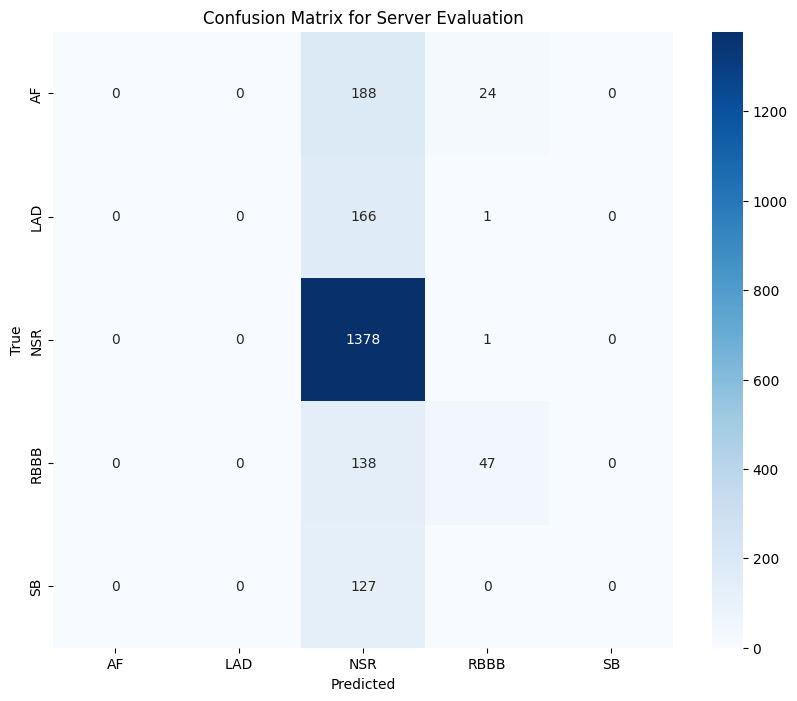

INFO flwr 2024-07-01 22:17:25,956 | server.py:125 | fit progress: (1, 0.05519182563259982, {'accuracy': 0.6884057971014492, 'f1': 0.23613835923435836, 'precision': 0.2667741338034449, 'recall': 0.2506657781784686}, 48.21301379999932)
DEBUG flwr 2024-07-01 22:17:25,956 | server.py:173 | evaluate_round 1: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.05519182563259982 / accuracy 0.6884057971014492


(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
(DefaultActor pid=13816)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
(DefaultActor pid=13816)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

(DefaultActor pid=13816) [Client 1] evaluate, config: {}
(DefaultActor pid=2476) [Client 1] fit, config: {}
(DefaultActor pid=2476) [Client 7] fit, config: {}
(DefaultActor pid=13816) Epoch 2: train loss 0.042479146271944046, accuracy 0.6453634085213033 [repeated 11x across cluster]


DEBUG flwr 2024-07-01 22:17:29,224 | server.py:236 | fit_round 2 received 2 results and 0 failures
c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


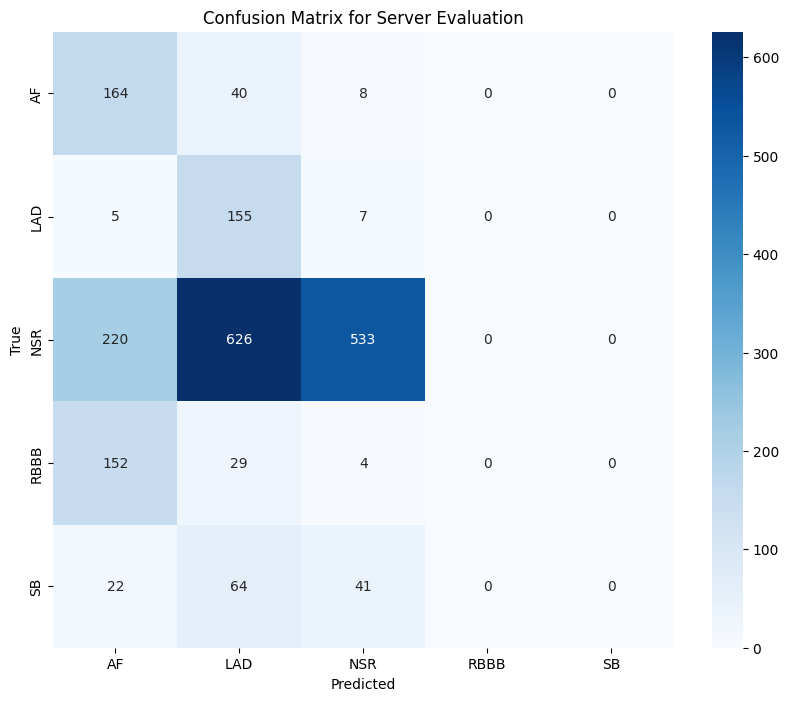

INFO flwr 2024-07-01 22:17:30,374 | server.py:125 | fit progress: (2, 0.04330093422949602, {'accuracy': 0.4115942028985507, 'f1': 0.25011305312663223, 'precision': 0.27194008637000894, 'recall': 0.4176481166854792}, 52.61747440000181)
DEBUG flwr 2024-07-01 22:17:30,374 | server.py:173 | evaluate_round 2: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.04330093422949602 / accuracy 0.4115942028985507


DEBUG flwr 2024-07-01 22:17:30,687 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2024-07-01 22:17:30,687 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 8)


(DefaultActor pid=2476) [Client 1] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-07-01 22:17:31,453 | server.py:236 | fit_round 3 received 2 results and 0 failures
c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(DefaultActor pid=13816) [Client 1] fit, config: {} [repeated 3x across cluster]


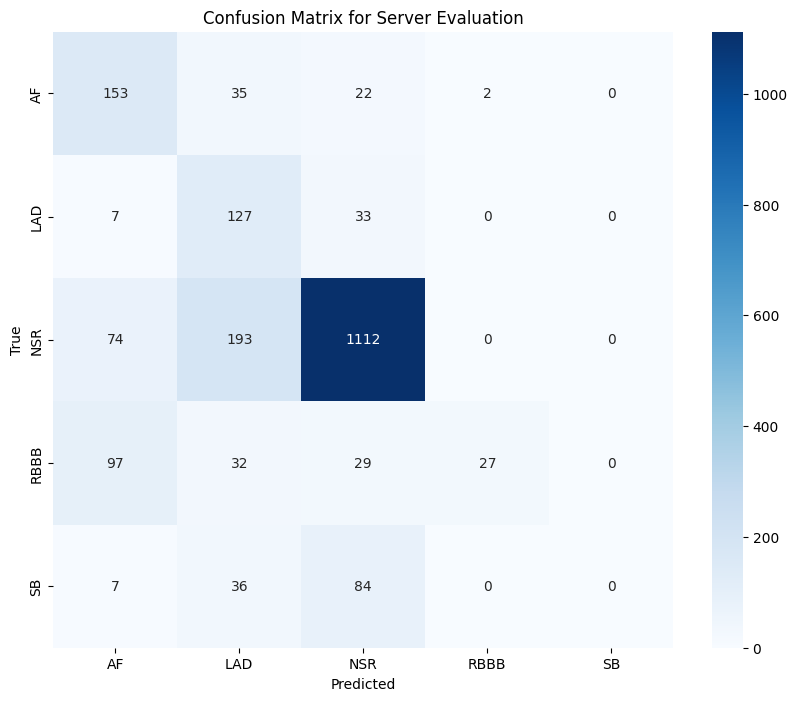

INFO flwr 2024-07-01 22:17:32,395 | server.py:125 | fit progress: (3, 0.026073830369589986, {'accuracy': 0.6855072463768116, 'f1': 0.4151226445890669, 'precision': 0.5105367222542994, 'recall': 0.4869009073785442}, 54.642047500001354)
DEBUG flwr 2024-07-01 22:17:32,395 | server.py:173 | evaluate_round 3: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.026073830369589986 / accuracy 0.6855072463768116


DEBUG flwr 2024-07-01 22:17:32,656 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2024-07-01 22:17:32,658 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 8)
(DefaultActor pid=2476) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior. [repeated 16x across cluster]
(DefaultActor pid=2476)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)) [repeated 16x across cluster]
(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this co

(DefaultActor pid=2476) Epoch 5: train loss 0.013873379677534103, accuracy 0.8456014362657092 [repeated 14x across cluster]


DEBUG flwr 2024-07-01 22:17:34,855 | server.py:236 | fit_round 4 received 2 results and 0 failures
c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


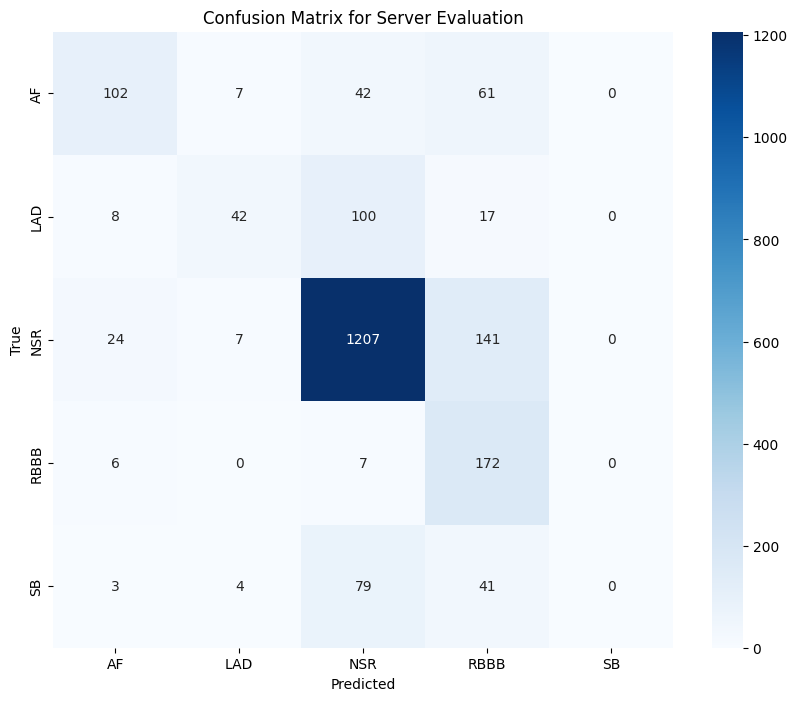

INFO flwr 2024-07-01 22:17:35,777 | server.py:125 | fit progress: (4, 0.02893869308169913, {'accuracy': 0.7357487922705314, 'f1': 0.47201639923179384, 'precision': 0.5305099688026518, 'recall': 0.5075261494750187}, 58.028758800002834)
DEBUG flwr 2024-07-01 22:17:35,777 | server.py:173 | evaluate_round 4: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.02893869308169913 / accuracy 0.7357487922705314


DEBUG flwr 2024-07-01 22:17:36,026 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2024-07-01 22:17:36,026 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 8)


(DefaultActor pid=13816) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=2476) [Client 4] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=2476) Epoch 4: train loss 0.022043034434318542, accuracy 0.7497911445279867 [repeated 19x across cluster]


DEBUG flwr 2024-07-01 22:17:38,028 | server.py:236 | fit_round 5 received 2 results and 0 failures
c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


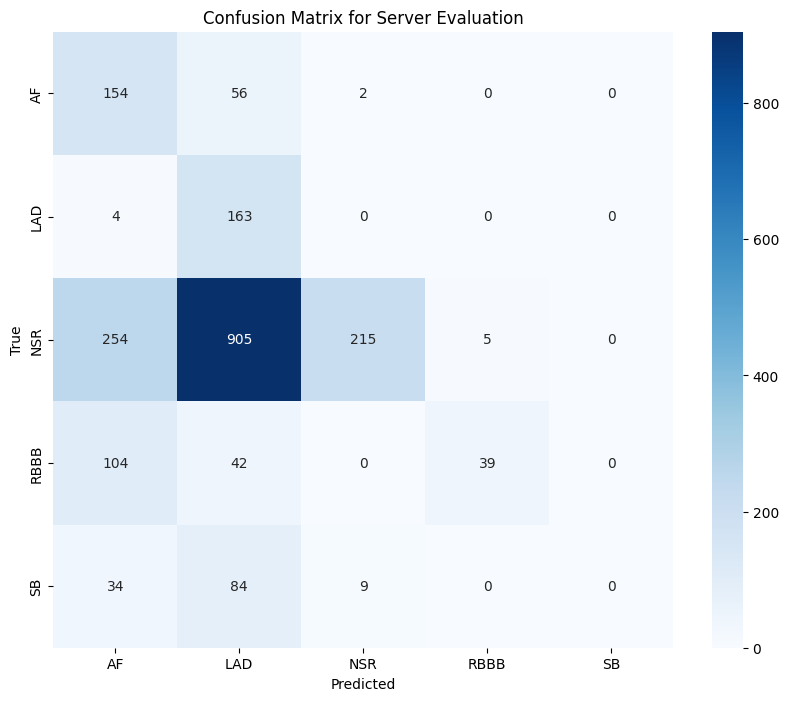

INFO flwr 2024-07-01 22:17:38,810 | server.py:125 | fit progress: (5, 0.07426361127752037, {'accuracy': 0.2758454106280193, 'f1': 0.24855742316605225, 'precision': 0.44961821399839097, 'recall': 0.41383677782199957}, 61.05490490000011)
DEBUG flwr 2024-07-01 22:17:38,810 | server.py:173 | evaluate_round 5: strategy sampled 2 clients (out of 8)
(DefaultActor pid=2476) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior. [repeated 16x across cluster]
(DefaultActor pid=2476)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)) [repeated 16x across cluster]
(DefaultActor pid=2476) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please c

Server-side evaluation loss 0.07426361127752037 / accuracy 0.2758454106280193


DEBUG flwr 2024-07-01 22:17:38,996 | server.py:222 | fit_round 6: strategy sampled 2 clients (out of 8)


(DefaultActor pid=13816) [Client 4] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=2476) [Client 6] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=13816) Epoch 4: train loss 0.014108577743172646, accuracy 0.9191413815364752 [repeated 10x across cluster]


DEBUG flwr 2024-07-01 22:17:45,090 | server.py:236 | fit_round 6 received 2 results and 0 failures
c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


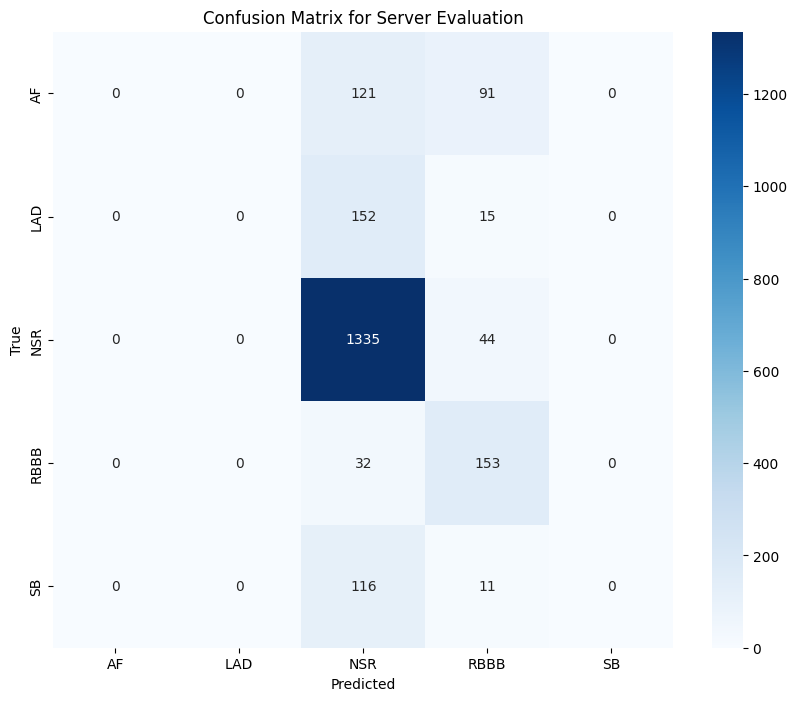

INFO flwr 2024-07-01 22:17:46,207 | server.py:125 | fit progress: (6, 0.0478225923102835, {'accuracy': 0.7188405797101449, 'f1': 0.29298021881082736, 'precision': 0.24950234319457945, 'recall': 0.3590239695823452}, 68.45610579999993)
DEBUG flwr 2024-07-01 22:17:46,207 | server.py:173 | evaluate_round 6: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.0478225923102835 / accuracy 0.7188405797101449


(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior. [repeated 8x across cluster]
(DefaultActor pid=13816)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)) [repeated 8x across cluster]
(DefaultActor pid=2476) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 2x across cluster]
(DefaultActor pid=2476)   client = check_clientfn_returns_client(client_fn(ci

(DefaultActor pid=2476) [Client 6] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=13816) [Client 2] fit, config: {} [repeated 2x across cluster]
(DefaultActor pid=13816) Epoch 4: train loss 0.0076091657392680645, accuracy 0.9344313238036047 [repeated 10x across cluster]


DEBUG flwr 2024-07-01 22:17:49,754 | server.py:236 | fit_round 7 received 2 results and 0 failures
c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


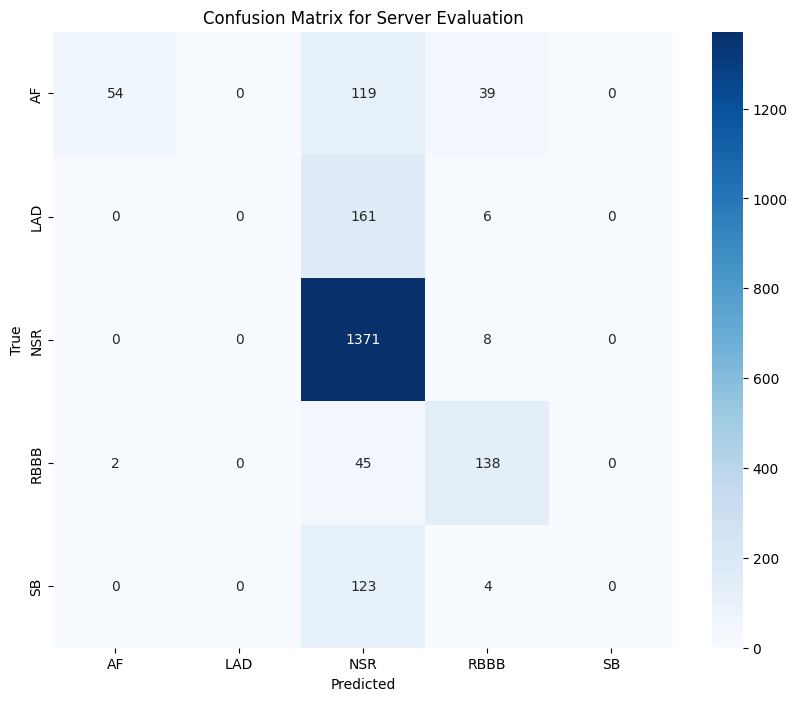

INFO flwr 2024-07-01 22:17:50,622 | server.py:125 | fit progress: (7, 0.05662651121040473, {'accuracy': 0.755072463768116, 'f1': 0.3973423491803351, 'precision': 0.48513777042089307, 'recall': 0.3989723243568661}, 72.86818259999927)
DEBUG flwr 2024-07-01 22:17:50,622 | server.py:173 | evaluate_round 7: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.05662651121040473 / accuracy 0.755072463768116


DEBUG flwr 2024-07-01 22:17:50,834 | server.py:187 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2024-07-01 22:17:50,834 | server.py:222 | fit_round 8: strategy sampled 2 clients (out of 8)
DEBUG flwr 2024-07-01 22:17:51,605 | server.py:236 | fit_round 8 received 2 results and 0 failures


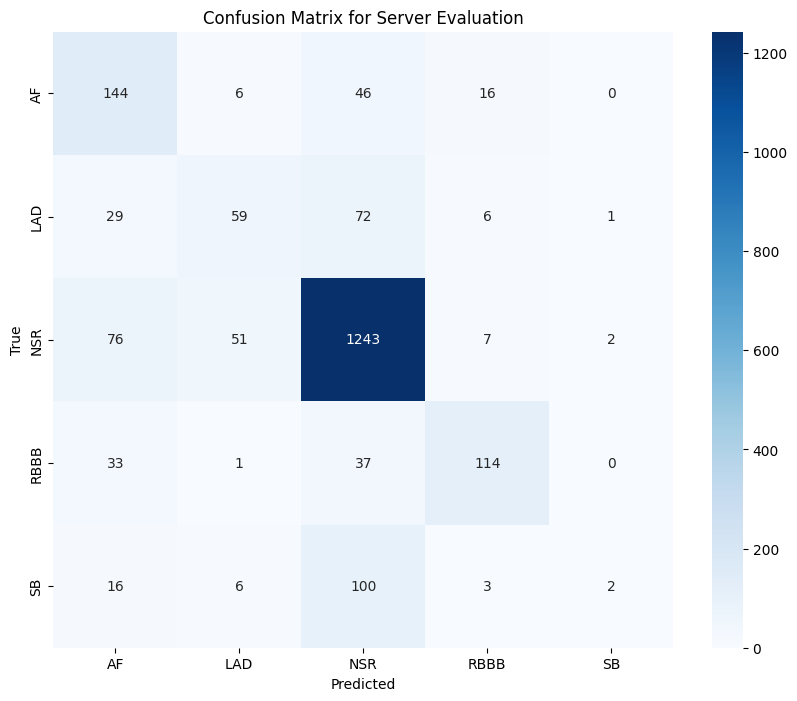

INFO flwr 2024-07-01 22:17:52,494 | server.py:125 | fit progress: (8, 0.02328733011432316, {'accuracy': 0.7545893719806763, 'f1': 0.510964351914526, 'precision': 0.5946982443547728, 'recall': 0.5131761507824103}, 74.74721490000229)
DEBUG flwr 2024-07-01 22:17:52,494 | server.py:173 | evaluate_round 8: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.02328733011432316 / accuracy 0.7545893719806763


(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior. [repeated 16x across cluster]
(DefaultActor pid=13816)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)) [repeated 16x across cluster]
(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 4x across cluster]
(DefaultActor pid=13816)   client = check_clientfn_returns_client(client_f

(DefaultActor pid=13816) [Client 6] evaluate, config: {} [repeated 3x across cluster]
(DefaultActor pid=13816) [Client 4] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=2476) Epoch 2: train loss 0.008458553813397884, accuracy 0.9366065879428216 [repeated 15x across cluster]


DEBUG flwr 2024-07-01 22:17:56,715 | server.py:236 | fit_round 9 received 2 results and 0 failures


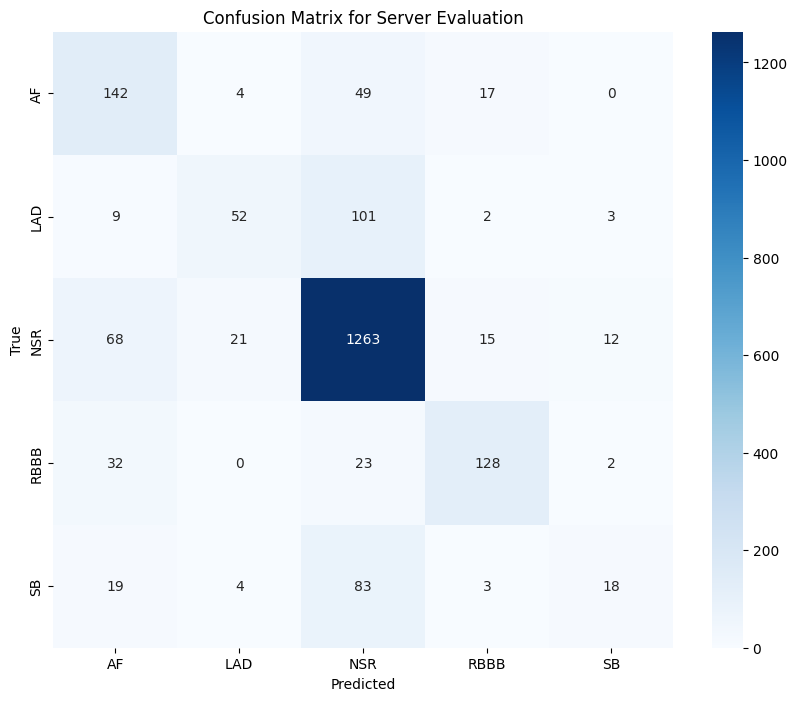

INFO flwr 2024-07-01 22:17:58,071 | server.py:125 | fit progress: (9, 0.023979297834605985, {'accuracy': 0.7743961352657005, 'f1': 0.5667705722767555, 'precision': 0.6578825191421197, 'recall': 0.5461387629723274}, 80.3157667000014)
DEBUG flwr 2024-07-01 22:17:58,071 | server.py:173 | evaluate_round 9: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.023979297834605985 / accuracy 0.7743961352657005


(DefaultActor pid=2476) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior. [repeated 4x across cluster]
(DefaultActor pid=2476)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)) [repeated 4x across cluster]
(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 2x across cluster]
(DefaultActor pid=13816)   client = check_clientfn_returns_client(client_fn(ci

(DefaultActor pid=2476) [Client 0] evaluate, config: {} [repeated 2x across cluster]
(DefaultActor pid=13816) [Client 6] fit, config: {}
(DefaultActor pid=2476) [Client 0] fit, config: {}
(DefaultActor pid=2476) Epoch 4: train loss 0.008345433510839939, accuracy 0.9102333931777379 [repeated 12x across cluster]


DEBUG flwr 2024-07-01 22:17:59,928 | server.py:236 | fit_round 10 received 2 results and 0 failures


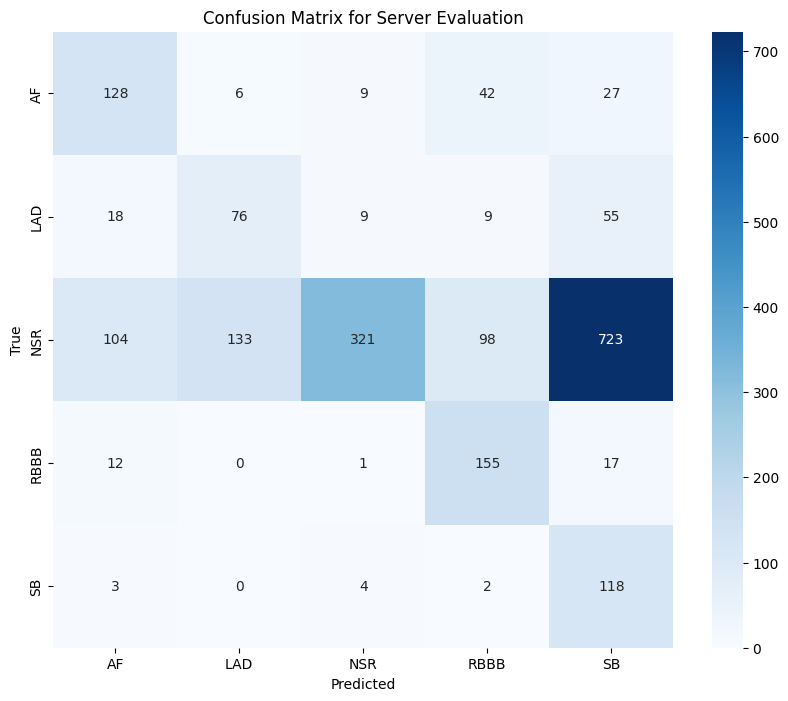

INFO flwr 2024-07-01 22:18:01,326 | server.py:125 | fit progress: (10, 0.04397107403059512, {'accuracy': 0.3855072463768116, 'f1': 0.43194895063790356, 'precision': 0.4803429275014615, 'recall': 0.6117224952559701}, 83.57541839999976)
DEBUG flwr 2024-07-01 22:18:01,326 | server.py:173 | evaluate_round 10: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.04397107403059512 / accuracy 0.3855072463768116


DEBUG flwr 2024-07-01 22:18:01,609 | server.py:187 | evaluate_round 10 received 2 results and 0 failures
DEBUG flwr 2024-07-01 22:18:01,609 | server.py:222 | fit_round 11: strategy sampled 2 clients (out of 8)


(DefaultActor pid=2476) [Client 0] fit, config: {}
(DefaultActor pid=2476) [Client 4] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-07-01 22:18:03,966 | server.py:236 | fit_round 11 received 2 results and 0 failures
c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(DefaultActor pid=13816) [Client 3] fit, config: {}


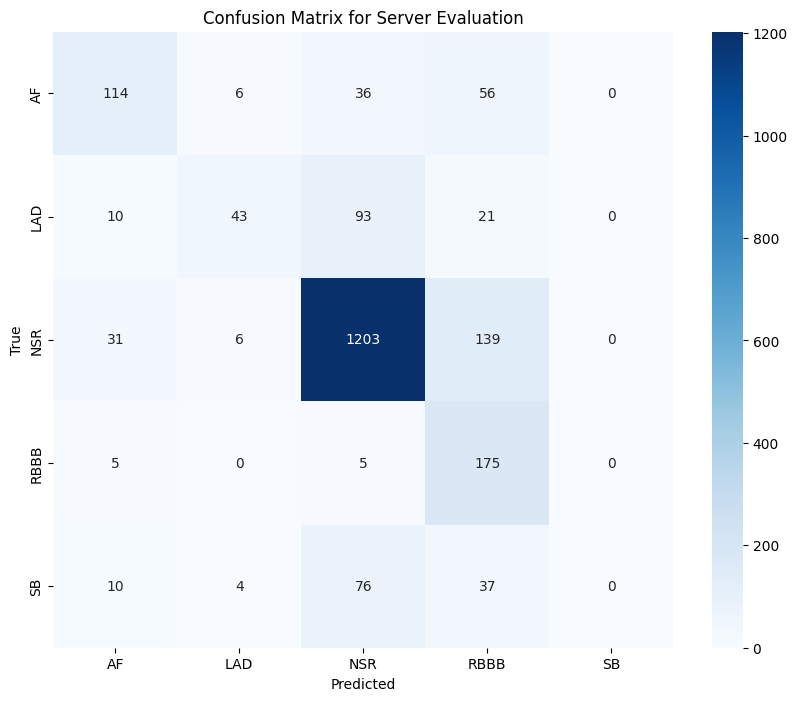

INFO flwr 2024-07-01 22:18:05,007 | server.py:125 | fit progress: (11, 0.03420448109579547, {'accuracy': 0.7415458937198067, 'f1': 0.48201998856122624, 'precision': 0.5319320683503788, 'recall': 0.5227076216962931}, 87.25175230000241)
DEBUG flwr 2024-07-01 22:18:05,007 | server.py:173 | evaluate_round 11: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.03420448109579547 / accuracy 0.7415458937198067
(DefaultActor pid=13816) Epoch 5: train loss 0.00975143350660801, accuracy 0.8830409356725146 [repeated 14x across cluster]


(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
(DefaultActor pid=13816)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 4x across cluster]
(DefaultActor pid=13816)   client = check_clientfn_returns_client(client_fn(cid)) [repeated 4x across cluster]
(DefaultActor pid=2476)

(DefaultActor pid=2476) [Client 0] fit, config: {}


DEBUG flwr 2024-07-01 22:18:06,506 | server.py:236 | fit_round 12 received 2 results and 0 failures


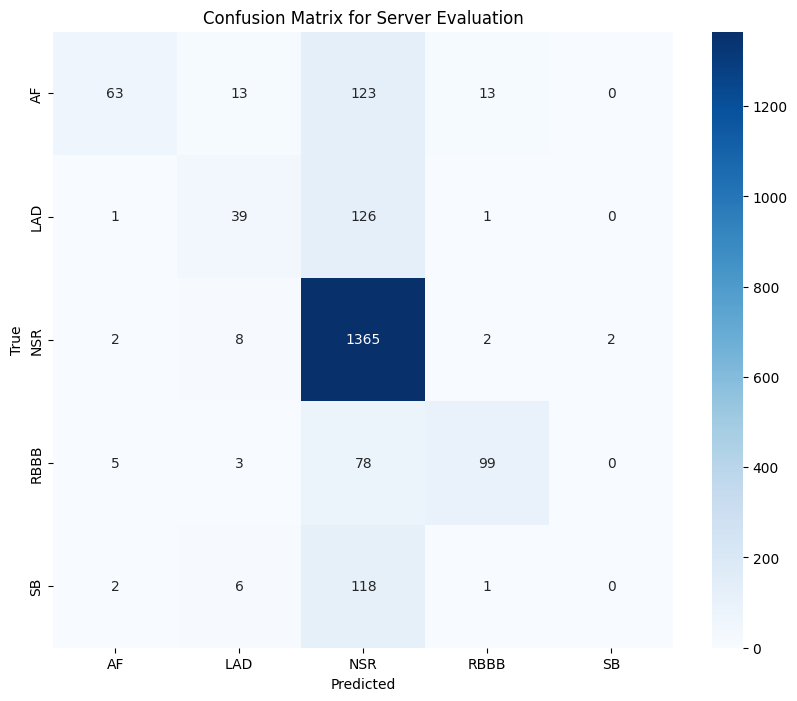

INFO flwr 2024-07-01 22:18:07,592 | server.py:125 | fit progress: (12, 0.04115258318502546, {'accuracy': 0.7565217391304347, 'f1': 0.45729775590717486, 'precision': 0.6071646024410786, 'recall': 0.4111371192647334}, 89.83942220000245)
DEBUG flwr 2024-07-01 22:18:07,592 | server.py:173 | evaluate_round 12: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.04115258318502546 / accuracy 0.7565217391304347


DEBUG flwr 2024-07-01 22:18:07,859 | server.py:187 | evaluate_round 12 received 2 results and 0 failures
DEBUG flwr 2024-07-01 22:18:07,859 | server.py:222 | fit_round 13: strategy sampled 2 clients (out of 8)


(DefaultActor pid=2476) [Client 5] evaluate, config: {} [repeated 4x across cluster]


DEBUG flwr 2024-07-01 22:18:10,468 | server.py:236 | fit_round 13 received 2 results and 0 failures


(DefaultActor pid=13816) Epoch 5: train loss 0.015270327217876911, accuracy 0.8266499582289056 [repeated 20x across cluster]
(DefaultActor pid=13816) [Client 4] fit, config: {} [repeated 3x across cluster]


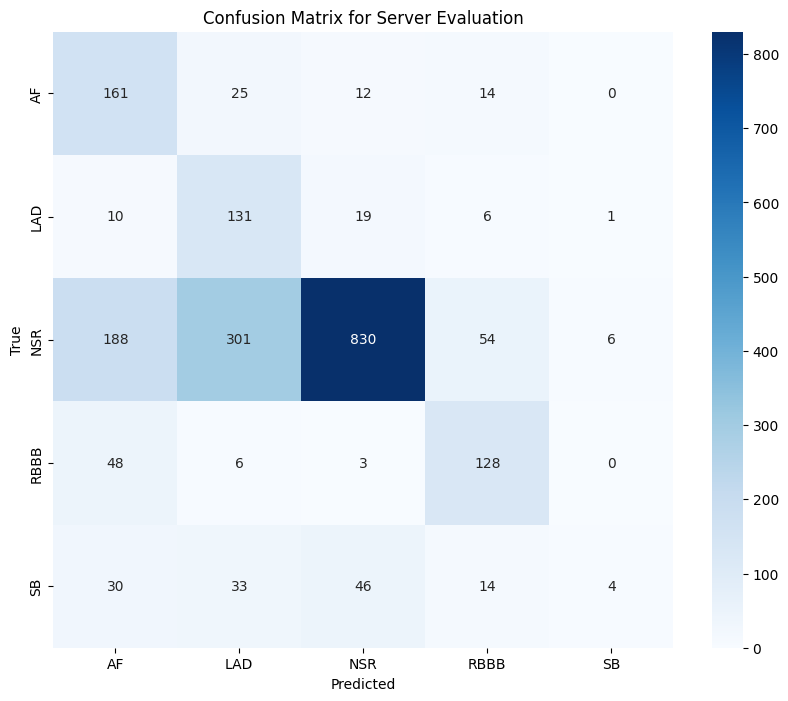

INFO flwr 2024-07-01 22:18:11,503 | server.py:125 | fit progress: (13, 0.039386207326022896, {'accuracy': 0.6057971014492753, 'f1': 0.46258077851794954, 'precision': 0.5001701648348507, 'recall': 0.5738276958186338}, 93.75686420000056)
DEBUG flwr 2024-07-01 22:18:11,503 | server.py:173 | evaluate_round 13: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.039386207326022896 / accuracy 0.6057971014492753


(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 4x across cluster]
(DefaultActor pid=13816)   client = check_clientfn_returns_client(client_fn(cid)) [repeated 4x across cluster]
(DefaultActor pid=13816) INFO flwr 2024-07-01 22:18:11,671 | 452360084.py:32 | Client side accuracy: 0.5892547660311959 [repeated 5x across cluster]
(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

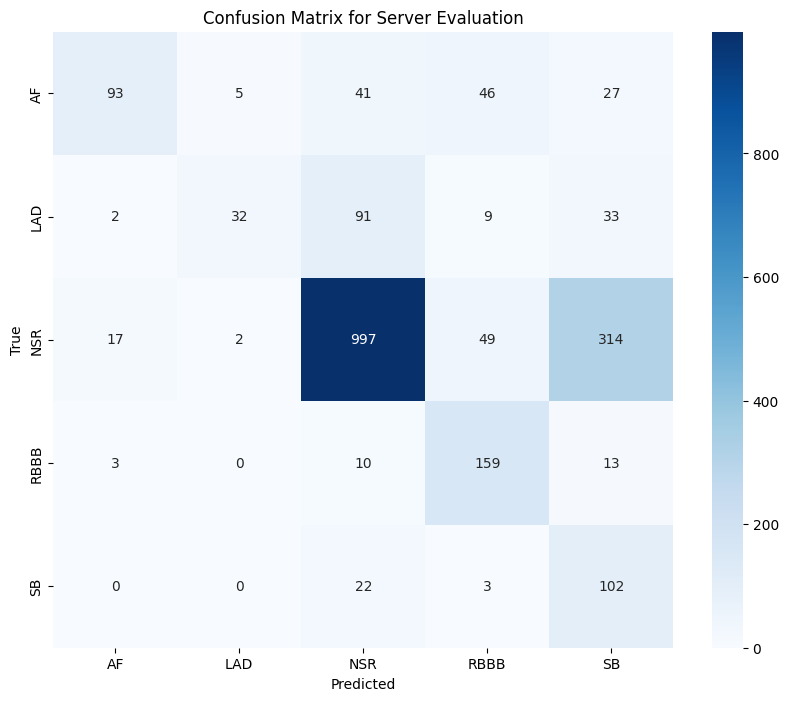

INFO flwr 2024-07-01 22:18:14,415 | server.py:125 | fit progress: (14, 0.029904063816231806, {'accuracy': 0.6681159420289855, 'f1': 0.5401589861236216, 'precision': 0.6588568508075661, 'recall': 0.6031785499470016}, 96.66829119999966)
DEBUG flwr 2024-07-01 22:18:14,426 | server.py:173 | evaluate_round 14: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.029904063816231806 / accuracy 0.6681159420289855
(DefaultActor pid=13816) [Client 2] evaluate, config: {} [repeated 3x across cluster]


DEBUG flwr 2024-07-01 22:18:14,783 | server.py:187 | evaluate_round 14 received 2 results and 0 failures
DEBUG flwr 2024-07-01 22:18:14,786 | server.py:222 | fit_round 15: strategy sampled 2 clients (out of 8)


(DefaultActor pid=13816) Epoch 3: train loss 0.007734362035989761, accuracy 0.9210053859964094 [repeated 14x across cluster]
(DefaultActor pid=13816) [Client 0] fit, config: {} [repeated 4x across cluster]


DEBUG flwr 2024-07-01 22:18:17,226 | server.py:236 | fit_round 15 received 2 results and 0 failures
c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


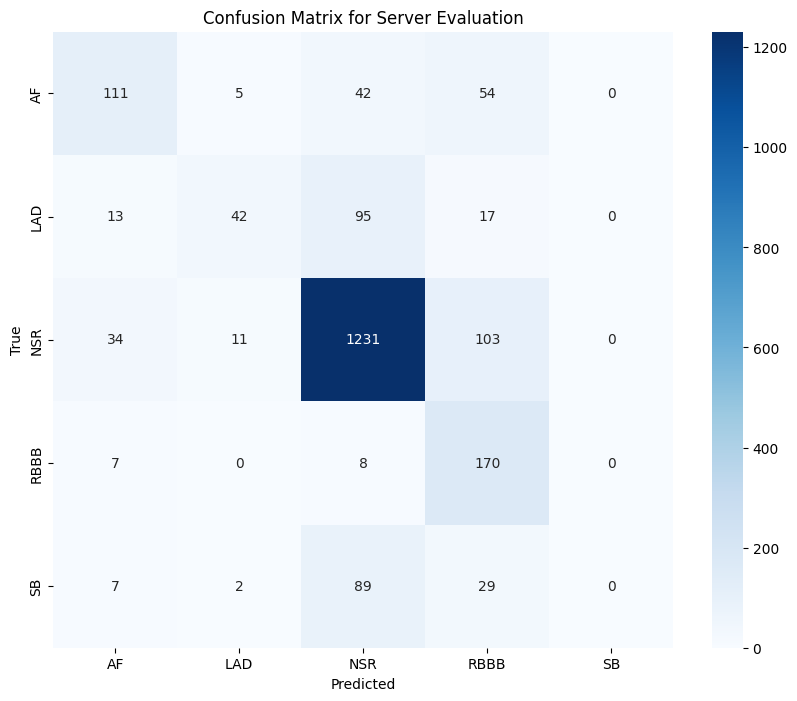

INFO flwr 2024-07-01 22:18:18,394 | server.py:125 | fit progress: (15, 0.043241274720372785, {'accuracy': 0.7507246376811594, 'f1': 0.4846340374226486, 'precision': 0.5282771899637977, 'recall': 0.5173353365268071}, 100.63895530000082)
DEBUG flwr 2024-07-01 22:18:18,398 | server.py:173 | evaluate_round 15: strategy sampled 2 clients (out of 8)


Server-side evaluation loss 0.043241274720372785 / accuracy 0.7507246376811594


(DefaultActor pid=13816) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 4x across cluster]
(DefaultActor pid=13816)   client = check_clientfn_returns_client(client_fn(cid)) [repeated 4x across cluster]
(DefaultActor pid=2476) INFO flwr 2024-07-01 22:18:18,574 | 452360084.py:32 | Client side accuracy: 0.7377049180327869 [repeated 4x across cluster]
(DefaultActor pid=2476) c:\Users\adity\Anaconda3\envs\thesis_env\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter 

In [61]:
# Create an instance of the model and get the parameters
params = get_parameters(Net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.3,
    fraction_evaluate=0.3,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=n_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn = evaluate,
    evaluate_metrics_aggregation_fn = average_metrics
)

# strategy = AggregateCustomMetricStrategy(
#     fraction_fit=0.7,
#     fraction_evaluate=0.3,
#     min_fit_clients=2,
#     min_evaluate_clients=2,
#     min_available_clients=n_clients,
#     initial_parameters=fl.common.ndarrays_to_parameters(params),
#     evaluate_fn = evaluate,
# )


# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
history_sim = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=n_clients,
    config=fl.server.ServerConfig(num_rounds=15),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
    #ray_init_args={"include_dashboard": True}
)

In [49]:
#save all metrics from history_sim as df csv 

history_distributed = pd.DataFrame(history_sim.metrics_distributed)
history_centralized = pd.DataFrame(history_sim.metrics_centralized)



In [62]:
history_distributed.to_csv(r"C:\Users\adity\FL_practice\FL_results_new\Non-IID Dist Scaling\history_dis_15_rounds_8_clients_5_classes.csv",index=False)

In [63]:
history_centralized.to_csv(r"C:\Users\adity\FL_practice\FL_results_new\Non-IID Dist Scaling\history_cent_15_rounds_8_clients_5_classes.csv",index=False)